## 대출 상환 예측 데이터
* https://www.kaggle.com/c/home-credit-default-risk

* 고객 정보를 기반으로 대출 상환 가능 여부 예측(0이면 상환 가능, 1이면 상환 불가능)
* 메인 테이블(application_train, application_test)만 사용 예정

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## import 라이브러리

In [ ]:
# 데이터 가공을 위한 numpy, pandas
import numpy as np
import pandas as pd

# 범주형 변수를 다루기 위한 sklearn preprocessing
from sklearn.preprocessing import LabelEncoder

# File system 관리
import os

# 경고 방지
import warnings
warnings.filterwarnings('ignore')

# 시각화 툴 matplotlib, seaborn
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# 사용 가능한 파일 목록 확인
print(os.listdir("../input/"))

In [ ]:
# Training data
train_data = pd.read_csv('../input/home-credit-default-risk/application_train.csv')
print('Training data shape: ', train_data.shape)
train_data.head()

In [ ]:
# Testing data 
test_data = pd.read_csv('../input/home-credit-default-risk/application_test.csv')
print('Testing data shape: ', test_data.shape)
test_data.head()

---
## EDA

## 1) TARGET 컬럼 확인
TARGET은 예측해야하는 값. 0이면 상환 가능, 1이면 상환이 불가능을 의미

In [ ]:
train_data['TARGET'].value_counts()

In [ ]:
train_data['TARGET'].astype(int).plot.hist();

* 0이 1값보다 굉장히 많은 것을 알 수 있다.

## 2) 결측치 확인
각 컬럼의 결측치 개수 및 비중 확인

In [ ]:
# 전체 결측치 개수확인
mis_val = train_data.isnull().sum()

# 결측치 비중 확인
mis_val_percent = 100*train_data.isnull().sum()/len(train_data)

# 결측치 개수, 결측치 비중 테이블 만들기
mis_val_table = pd.concat([mis_val, mis_val_percent],axis=1)

#컬럼 이름 바꾸기
mis_val_table_ren_columns = mis_val_table.rename(columns={0:'Missing Values',1:'% of Total Values'})

#결측치 0인 컬럼 제외 및 정렬
mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,1]!=0].sort_values('% of Total Values',ascending=False).round(1)

mis_val_table_ren_columns

* 67개의 컬럼에 결측치가 포함되어있다.
* 위의 결측치들을 채워야한다.(imputation)
* 결측치가 너무 많은 컬럼은 삭제할 수도 있지만, 모델 성능에 도움이 될 수도 있기 때문에 우선 유지

## 3) Column Types
int64,float64 타입은 수치형 변수, object 타입은 범주형 변수

In [ ]:
train_data.dtypes.value_counts()

In [ ]:
# 범주형 변수에서 유니크한 값의 개수 확인
# train_data.select_dtypes('object').apply(pd.Series.nunique)
train_data.select_dtypes('object').nunique() # apply 함수 없이 가능

* OCCUPATION_TYPE과 ORGANIZATION_TYPE을 제외하면 범주형 변수는 유니크한 값이 적음

## 4) 범주형 변수 Encoding
LightGBM같은 모델을 제외하고 대부분의 머신러닝 모델은 범주형 변수를 다룰 수 없기 때문에, 이러한 범주형 변수를 encode 해줘야한다. 그 방법으로는 아래 두가지가 있다.

1) Lable Encoding:
 * 범주형 변수의 개별값을 숫자로 바꿔주는 방법. 컬럼을 새로 생성하지 않음
 * 여성/남성 처럼 범주형 변수의 값이 두개일 경우는 Label Encoding을 사용해도 무관하지만, 그 이상일 경우는 One-Hot Enconding을 사용하는 것이 좋음
 
2) One-Hot Encoding:
 * 피처 값의 유형에 따라 새로운 피처를 추가해 고유값에 해당하는 컬럼에만 1을 표시하고 나머지 컬럼에는 0을 표시하는 방법
 * One-Hot Encoding의 경우 범주형 변수의 유니크한 값의 개수만큼 컬럼이 늘어난다는 것(이를 보완하기 위해 PCA같은 차원축소 방법을 사용할 수도 있음)

이 노트북에서는 범주형 변수의 유니크한 값이 2개일 경우 Label Encoding을 사용하고 그 이상일 경우 One-Hot Encoding을 사용할 것이다.

### Label Encoding and One-Hot Encoding

In [ ]:
le = LabelEncoder()
le_count = 0

# 컬럼별로 iterate 돌기
for col in train_data:
    if train_data[col].dtype=='object':
        # 데이터 타입이 object이고, 값의 종류가 두개 이하일 경우,
        if len(list(train_data[col].unique())) <=2:
            
            # train과 test에 동일하게 라벨 인코딩을 하기 위해 train 기준으로 fit한 값을 train, test에 동일하게 transform
            le.fit(train_data[col])
            
            # train-set, test-set 모두 Transform
            train_data[col]=le.transform(train_data[col])
            test_data[col]=le.transform(test_data[col])
            
            # Label Encoding을 한 컬럼이 몇개인지 카운트
            le_count+=1
print('%d columns were label encoded.' % le_count)

In [ ]:
# Label Encoding 적용 안한 나머지 범주형 변수에 One-Hot-Encoding 적용
train_data = pd.get_dummies(train_data)
test_data = pd.get_dummies(test_data)

print('Training Features shape: ', train_data.shape)
print('Testing Features shape: ', test_data.shape)

## 5) Train data와 Test data 컬럼 맞춰주기
train 데이터와  test 데이터에는 동일한 feature가 있어야한다.
train 데이터에 있는 카테고리 변수의 유니크한 값 개수와 test 데이터에 있는 카테고리 변수의 유니크한 값 개수가 다른 변수들이 있어서 One-Hot Encoding을 했더니, train에는 있는데 test에는 없는 컬럼들이 생겨버림

따라서 test 데이터에는 없고 train에만 있는 컬럼을 삭제(TARGET 컬럼은 제외)

In [ ]:
# TARGET변수는 train데이터에만 있지만 필요한 변수이기때문에 따로 빼두고나서 다시추가할것
train_labels=train_data['TARGET']

"""
두 데이터프레임에 모두 있는 컬럼들만 유지하면서 train-set과 test-set을 align한다.
즉, train 데이터와 test 데이터에 둘다 있는 컬럼들의 값만 가져오려는것
"""

train_data, test_dat = train_data.align(test_data,join='inner',axis=1)

# TARGET변수 다시 추가
train_data['TARGET']=train_labels

print('Training Features shape: ', train_data.shape)
print('Testing Features shape: ', test_data.shape)

## 6) 이상치(Anomalies)
* 극단치 / 아웃라이어(Outlier)
*  이상치를 발견할 수 있는 방법 중 하나는 describe() 메소드로 컬럼의 통계값들을 보는 것이다,

In [ ]:
# DAYS_BIRTH: 신청일 기준 나이(이상치 없어보임)
(train_data['DAYS_BIRTH']/-365).describe()

In [ ]:
# DAYS_EMPLOYED: 신청일 기준 현재 직장에서 일한 일 수(이상치)
train_data['DAYS_EMPLOYED'].describe()

In [ ]:
train_data['DAYS_EMPLOYED'].plot.hist(title='Days Employment Histogram')
plt.xlabel('Days Employment')

이상치인것 같은 고객들은 따로 빼서 그들의 대출상환 비율이 그외의 고객들에비해 높거나 낮은 경향이 있는지 파악해보자

In [ ]:
# 이상치
anom=train_data[train_data['DAYS_EMPLOYED']==365243]
# 이상치 외
non_anom=train_data[train_data['DAYS_EMPLOYED']!=365243]

print('The non-anomalies default on %0.2f%% of loans' %(100*non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

* 이상치로 보이는 고객들이 대출을 상환하지못할 확률이 5.4%로 더 낮음.
* 이상치를 다루는 가장 안전한 방법은 결측치 채우듯이 채우는 방법
* 이 경우 모든 이상치들이 같은값을 갖고 있으므로, 다 같은 값으로 채울것이다.
* 이상값들이 중요해보이니, 머신러닝 모델에 이 이상값들을 임의로 채운것에대해 알려줄것이다.

> 결론적으로
    * 이상값을 숫자로 채우지 않고, 새로운 boolean 컬럼을 만들어서 이상값인지 아닌지를 구분할것이다.

In [ ]:
# Create an anomalous flag column
## 이상치(365243)인 값에 대해서 True , False로 구분
train_data['DAYS_EMPLOYED_ANOM'] = train_data["DAYS_EMPLOYED"] == 365243

# 이상치를 nan값으로 대치
train_data['DAYS_EMPLOYED'].replace({365243:np.nan},inplace=True)

train_data['DAYS_EMPLOYED'].plot.hist(title='Days Employment Histogram');
plt.xlabel('Days Employment');

In [ ]:
# test data에도 train data와 동일하게 작업
# test 데이터에도 train 데이터와 동일하게 작업
test_data['DAYS_EMPLOYED_ANOM']=test_data['DAYS_EMPLOYED']==365243
test_data['DAYS_EMPLOYED'].replace({365243:np.nan}, inplace=True)

# True, False로 되어있는 데이터 sum하면 True인것 개수 카운팅됨.
print('There are %d anomalies in the test data out of %d entries'%(test_data['DAYS_EMPLOYED_ANOM'].sum(), len(test_data)))

## 7) Correlation(상관관계)

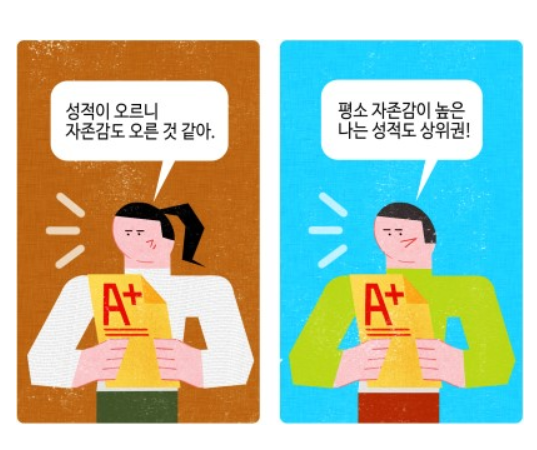

* 카테고리형 변수와 Outlier
* 데이터를 이해하는 방법 중 하나는 변수간, 그리고 Target과의 상관관계를 살펴보는 것
 * 상관은 2가지 케이스로 나뉨 -> 상관계수가 양(+), 음(-)
     * 양(+)의 경우를 정적, 음(-)의 경우를 부적이라 함
* .corr()를 사용해서 변수간, 그리고 Target 변수와의 Pearson 상관관계를 살펴보자
    * 상관계수는 Pearson 상관계수를 사용하며 -1~1 의 값을 가짐

In [ ]:
# TARGET 변수와의 상관관계
correlations = train_data.corr()['TARGET'].sort_values()

print('Most Positive Correlations: \n', correlations.tail(15))
print('\nMost Negative Correlations: \n', correlations.head(15))

* DAYS_BIRTH 컬럼이 가장 양의 상관성이 높다. 그러나 이 변수의 값들은 실제로 음수이다.
* 이 의미는 고객의 나이가 많을수록 대출 상환 가능성이 적다라는 것을 의미하고, 이는 DAYS_BIRTH가 음수이기 때문이다. 따라서, DAYS_BIRTH에 절대값을 취해서 다시 상관관계를 확인하려고 한다.

In [ ]:
# DAYS_BIRTH의 절대값과 TARGET 변수와의 상관계수
train_data['DAYS_BIRTH']=abs(train_data['DAYS_BIRTH'])
train_data['DAYS_BIRTH'].corr(train_data['TARGET'])

* 절대값을 취해서 다시 TARGET과의 상관계수를 보니 고객의 나이가 많을 수록 대출을 상환할 가능성이 높다고 나옴

In [ ]:
plt.style.use('fivethirtyeight')

# 고객 나이에 대한 히스토그램 분포 확인
plt.hist(train_data['DAYS_BIRTH']/365, edgecolor='k',bins=25)
plt.title('Age of Client');
plt.xlabel('Age (years)');
plt.ylabel('Count');

* 위의 분포를 살펴보니 outlier없이 나이가 고르게 분포되어있는 편. 
* 이제 나이가 TARGET에 미치는 영향을 시각화해서 보기위해 KDE plot을 그려볼것이다.

#### KDE(커널 밀도 추정) plot을 사용하는 이유
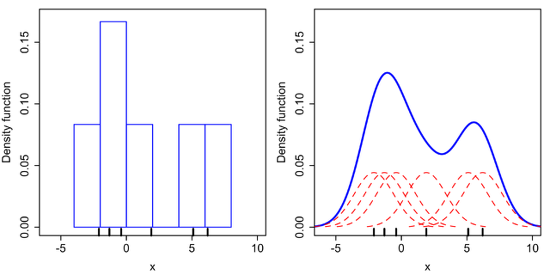
* binary의 경계에서 불연속, 크기&시작위치에 따라 달라짐, 고차원 데이터는 메모리 문제
* 그래서 그 대안으로 커널 밀도 추정(KDE) 그래프를 많이 사용함.
* 히스토그램 같은 분포를 곡선화해서 나타낸 그래프

In [ ]:
plt.figure(figsize=(10,8))

# 제때 대출을 상환하는 고객의 나이 plot (TARGET=0: 파란색)
sns.kdeplot(train_data.loc[train_data['TARGET']==0,'DAYS_BIRTH']/365,label='target==0')

# 제때 대출을 상환하지못하는 고객의 나이 plot (TARGET=1: 빨간색)
sns.kdeplot(train_data.loc[train_data['TARGET']==1,'DAYS_BIRTH']/365,label='target==1')

plt.xlabel('Age(years)');
plt.ylabel('Density');
plt.title('Distribution of Ages');

http://seaborn.pydata.org/
* Seaborn은 Matplotlib을 기반으로 다양한 색상 테마와 통계용 차트 등의 기능을 추가한 시각화 패키지이다.

* target==1(빨간색)의 분포를 보면 20-30대에 기울어 있는것을 볼 수 있다. 이는 젊은 층일수록 대출 상환을 못할 확률이 높다고 유추할 수 있음.
* target==0일때와 1일때의 TARGET과의 분포가 상이한것으로 보아 이 변수는 머신러닝 모델에 유용하게 활용될 것으로 보인다.
* 그럼이제 나이를 나이대 별로 그룹을 나눠서 target=1(대출 상환이 어려운) 의 평균값을 살펴보자.

In [ ]:
# 최소 20 최대 70으로해서 총 10개로 그룹핑
## 결과는 20이상 25미만, 25이상 30미만,,,, 으로 그룹핑됨. 단 (,)는 포함 [,]는 미포함을 의미
np.linspace(20,70,num=11)

In [ ]:
"""
cut() 함수를 사용해서 5살 간격으로 나이대 그룹을 나눠보자. 
그다음, 각 나이대 별로 대출상환을 못하는 비율을 체크
"""

age_data=train_data[['TARGET','DAYS_BIRTH']]
age_data['YEARS_BIRTH']=age_data['DAYS_BIRTH']/365

# Bin the age data
age_data['YEARS_BINNED']=pd.cut(age_data['YEARS_BIRTH'],bins=np.linspace(20,70,num=11))
age_data.head(10)

https://pandas.pydata.org/docs/reference/api/pandas.cut.html?highlight=cut#pandas.cut

In [ ]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

In [ ]:
plt.figure(figsize=(8,8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100*age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation=75);
plt.xlabel('Age Group (years)');
plt.ylabel('Failur to Reapy(%)')
plt.title('Failure to Repay by Age Group');

* https://wikidocs.net/92095 : 막대그래프 파라미터
* https://pandas.pydata.org/docs/reference/api/pandas.Index.astype.html

* 젊은층일수록 대출을 상환하지 못하는 것으로 나타남
* 20-25세, 25-30세 30-35세는 각각 약 10% 이상 대출을 상환하지 못했고, 55-60세, 60-65세, 65-70세는 5%이하로 대출을 상환하지 못했음.

## 8) Exterior Sources
* 음의 상관이 가장 높았던 3개의 변수 EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3 이다.
* 이 변수들은 외부에서 가져온 정규화된 score를 나타낸다.
* 그럼, 이제 TARGET 변수와 EXT_SOURCE와의 상관관계와 EXT_SOURCE 서로간의 상관관계를 살펴보자


**정규화**
* 머신러닝 알고리즘은 데이터가 가진 feature(특성)들을 비교하여 데이터의 패턴을 찾음.
* 그런데, 데이터가 가진 feature의 스케일이 심하게 차이가 나는 경우 문제가 생김.

**정규화에는 최대-최소 정규화, Z-점수 정규화가 있다**


1. (X - MIN) / (MAX-MIN)

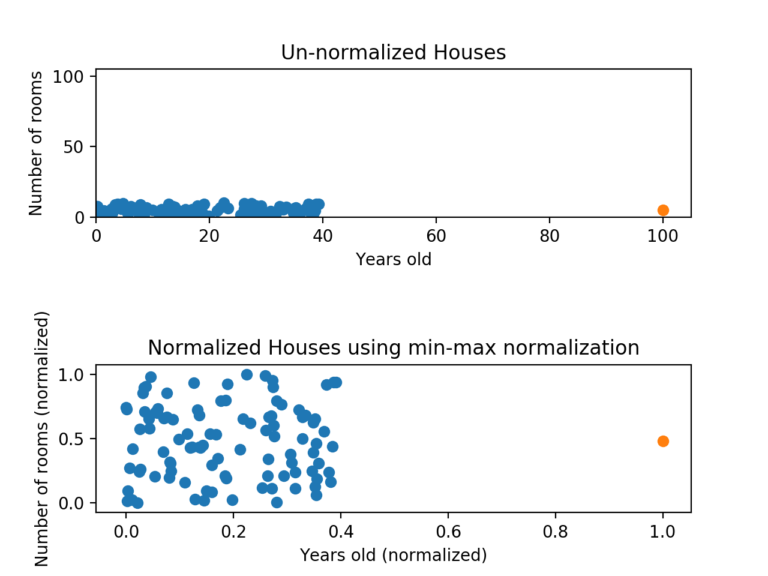


2. (X - 평균) / 표준편차

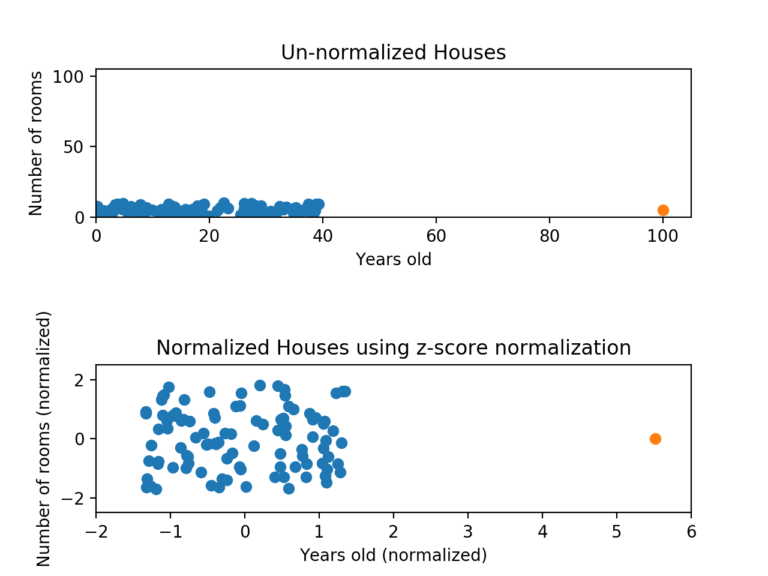

In [ ]:
ext_data=train_data[['TARGET','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','DAYS_BIRTH']]
ext_data_corrs=ext_data.corr()
ext_data_corrs

In [ ]:
plt.figure(figsize=(8,6))

sns.heatmap(ext_data_corrs, cmap=plt.cm.RdYlBu_r, vmin=-0.25, annot=True, vmax=0.6)
plt.title('Correlation Heatmap');

* EXT_SOURCE와 TARGET 변수는 음의 상관성을 띄므로, EXT_SOURCE값이 증가할수록 대출 상환을 잘한다는 의미로 해석가능.
* 또한, DAYS_BIRTH 변수는 EXT_SOURCE_1 변수와 양의 상관성이 높은것으로 보아 이 score중 하나는 고객의 나이일것으로 추정된다.
* 그 다음은 각 EXT_SOURCE 를 TARGET값 별로 나눠서 분포를 살펴보자.

In [ ]:
plt.figure(figsize=(10,12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']):
    plt.subplot(3,1,i+1)
    
    sns.kdeplot(train_data.loc[train_data['TARGET']==0,source],label='target==0')
    sns.kdeplot(train_data.loc[train_data['TARGET']==1,source],label='target==1')
    
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' %source);
    plt.ylabel('Density');
plt.tight_layout(h_pad=2.5)

* EXT_SOURCE_3 변수는 target값에 따라 차이가 가장 큰것으로 보인다.
* target 과의 상관계수가 그리 높지는 않지만, target이 0인지 1인지에 따라 값이 다른것으로 보아 모델에 영향을 주는 주요 변수라고 판단할 수 있음.

## 9) Pairs Plot(다변량 플롯)
* EXT_SOURCE 와 DAYS_BIRTH 변수간의 pair plot을 그려보자. 
* pair plot은 각각의 분포를 보여줄 뿐만 아니라, 여러 변수간의 관계도 보여주는 좋은 시각화이다.

In [ ]:
# Copy the data for plotting
plot_data=ext_data.drop(columns=['DAYS_BIRTH']).copy()

# 고객 나이 컬럼 추가
plot_data['YEARS_BIRTH']=age_data['YEARS_BIRTH']

# 결측치 drop
plot_data=plot_data.dropna().loc[:100000,:]

# 두 컬럼 간의 상관관계를 계산하는 함수 작성
def corr_func(x,y,**kwargs):
    r=np.corrcoef(x,y)[0][1]
    ax=plt.gca()
    ax.annotate("r={:.2f}".format(r),
               xy=(.2, .8),
               xycoords=ax.transAxes,
               size=20)

# Create the pairgrid object
## vars = 변수명 리스트
grid=sns.PairGrid(data=plot_data, size=3, diag_sharey=False, hue='TARGET',
                 vars=plot_data.columns.drop(['TARGET']).tolist())

# 삼각형 위쪽 영역은 산점도
grid.map_upper(plt.scatter,alpha=0.2)

# 대각선은 히스토그램
grid.map_diag(sns.kdeplot)

# 삼각형 하단은 density plot
grid.map_lower(sns.kdeplot, cmap=plt.cm.OrRd_r);

plt.suptitle('Ext Source and Age Features Pairs Plot',size=32, y=1.05);

* https://seaborn.pydata.org/generated/seaborn.PairGrid.html
* 위의 결과에서 빨간색은 대출 상환을 못하는경우, 파란색은 대출 상환하는 경우를 나타냄.
* EXT_SOURCE_1과 YEARS_BIRTH 간의 양의 선형관계가 나타난다.

## 10) Feature engineering
* 모델 정확도를 높이기 위해서 주어진 데이터를 예측 모델의 문제를 잘 표현할 수 있는 features로 변형시키는 과정.

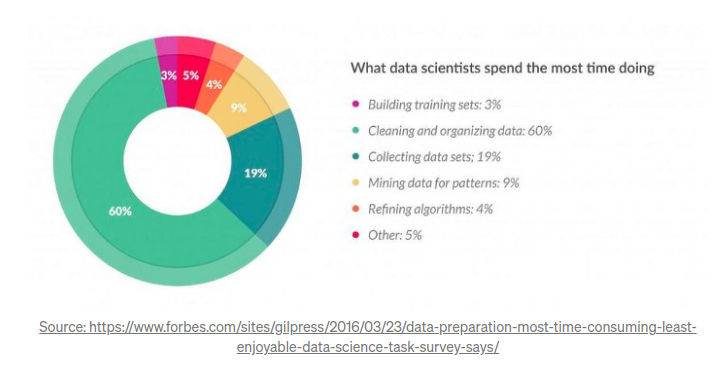

1. 머신 러닝 알고리즘에 걸맞는 적당한 입력 데이터셋을 준비
2. 머신 러닝 모델의 성능을 향상시키는 것

### Polynomial Features(다항회귀)
* 곡선 형태를 띄는 데이터를 제곱, 세제곱의 값으로 만들어서 일차방정식이 되도록 할 수 있음. 이렇게 dataset의 feature를 조정하여 다항식을 일차방정식으로 만들면 Gradient Descent 같은 알고리즘을 사용해서 학습시킬수 있음.

* 여기에서는 EXT_SOURCE_1를 제곱한값과 EXT_SOURCE_2를 제곱한 값, 그리고 EXT_SOURCE_1 x EXT_SOURCE_2 와 EXT_SOURCE_1 x EXT_SOURCE_2^2 같은 두 변수간의 곱을 새로운 변수로 만들 수 있다. 이러한 변수를 상호작용항 이라고 한다.

* 어떤 변수 각각은 target변수에 영향을 미치지 않을 수 있지만, 이 두 변수를 결합했을때 target변수에 영향을 미칠 수 있다.

* 상호작용항은 통계모델에서 다수의 변수들의 효과를 파악하기위해 사용되곤한다. 하지만 머신러닝에는 자주 사용되는것을 보지는 못했다. 그래서 한번 이 상호작용항이 모델예측력에 도움이 되는지 체크해볼것이다.

* 아래 코드에서 EXT_SOURCE, DAYS_BIRTH 변수를 사용해서 polynomial feature를 만들어볼것이다.

In [ ]:
'''
우선 다항식 적용할 변수들의 null값을 imputer로 채워준다.
'''
# Make a new dataframe for polynomial features
poly_features = train_data[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
poly_features_test = test_data[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

# 결측치 처리를 위해 imputer 호출
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')

# target값 따로 저장
poly_target=poly_features['TARGET']
# target값 제외한 나머지 변수 저장 
poly_features=poly_features.drop(columns=['TARGET'])

# 결측치 impute로 메꾸기 (train 데이터 기준으로 fit하고, train과 test에 둘다 transform 적용)
'''
train set 기준의 평균, 중간값 또는 최빈값으로 새로운 데이터의 null값을 채우는것
'''
poly_features=imputer.fit_transform(poly_features)
poly_features_test=imputer.transform(poly_features_test)

* https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html?highlight=imputer#sklearn.impute.SimpleImputer
* https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.transform.html

In [ ]:
# imputer 적용 후
poly_features

In [ ]:
poly_features_test

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

# Create the polynomial object with specified degree
poly_transformer=PolynomialFeatures(degree=3)

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html?highlight=polynomialfeatures#sklearn.preprocessing.PolynomialFeatures

In [ ]:
# Train the polynomial features (train데이터 기준으로 fit)
poly_transformer.fit(poly_features)

# Transform the features
poly_features=poly_transformer.transform(poly_features)
poly_features_test=poly_transformer.transform(poly_features_test)
print('Polynomial Features shape: ', poly_features.shape)

* get_feature_names 메소드를 사용해서 다항식 적용한 변수이름 확인

In [ ]:
poly_transformer.get_feature_names(input_features=['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])[:15]

* 35개의 feature가 만들어진것을 확인.이제 이 새로운 Feature들이 target과 상관관계가 있는지 확인해보자

In [ ]:
# Create a dataframe of the features 
poly_features = pd.DataFrame(poly_features, 
                             columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                           'EXT_SOURCE_3', 'DAYS_BIRTH']))
# drop했던 TARGET변수 다시 추가
poly_features['TARGET']=poly_target

# TARGET변수와의 상관관계 확인
poly_corrs=poly_features.corr()['TARGET'].sort_values()

# Display most negative and most positive
print(poly_corrs.head(10))
print(poly_corrs.tail(5))

* 다항식으로 만들어진 몇몇 새로운 변수들은 기존 변수보다 상관관계가 더 높다.(위에서 기존 변수와 TARGET변수와의 상관관계중 가장 높았던 값이 EXT_SOURCE_3 변수가 -0.18이었는데, 두 변수 EXT_SOURCE_2 EXT_SOURCE_3 를 조합한 변수는 -0.19로 더큼)

* 실제 이 변수가 모델에 영향이 있는지는 이 변수를 넣었을 때와 뺐을 때 둘다 테스트해보면된다.


In [ ]:
# Put test features into dataframe
poly_features_test = pd.DataFrame(poly_features_test, 
                                  columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                                'EXT_SOURCE_3', 'DAYS_BIRTH']))

# 원본 train 데이터에 새로 만든 다항변수를 merge해서 새로운 데이터셋 만들기
poly_features['SK_ID_CURR'] = train_data['SK_ID_CURR']
train_data_poly = train_data.merge(poly_features, on = 'SK_ID_CURR', how = 'left')

# 원본 test 데이터에 새로 만든 다항변수를 merge해서 새로운 데이터셋 만들기
poly_features_test['SK_ID_CURR'] = test_data['SK_ID_CURR']
test_data_poly = test_data.merge(poly_features_test, on = 'SK_ID_CURR', how = 'left')

# Align the dataframes => train데이터셋 기준으로 align 
train_data_poly, test_data_poly = train_data_poly.align(test_data_poly, join = 'inner', axis = 1)

# Print out the new shapes
print('Training data with polynomial features shape: ', train_data_poly.shape)
print('Testing data with polynomial features shape:  ', test_data_poly.shape)

### Domain Knowledge Features
* CREDIT_INCOME_PERCENT: the percentage of the credit amount relative to a client's income
* ANNUITY_INCOME_PERCENT: the percentage of the loan annuity relative to a client's income
* CREDIT_TERM: the length of the payment in months (since the annuity is the monthly amount due
* DAYS_EMPLOYED_PERCENT: the percentage of the days employed relative to the client's age

In [ ]:
train_data_domain = train_data.copy()
test_data_domain = test_data.copy()

# train data에 새로운 변수 추가
train_data_domain['CREDIT_INCOME_PERCENT'] = train_data_domain['AMT_CREDIT'] / train_data_domain['AMT_INCOME_TOTAL']
train_data_domain['ANNUITY_INCOME_PERCENT'] = train_data_domain['AMT_ANNUITY'] / train_data_domain['AMT_INCOME_TOTAL']
train_data_domain['CREDIT_TERM'] = train_data_domain['AMT_ANNUITY'] / train_data_domain['AMT_CREDIT']
train_data_domain['DAYS_EMPLOYED_PERCENT'] = train_data_domain['DAYS_EMPLOYED'] / train_data_domain['DAYS_BIRTH']

In [ ]:
test_data_domain['CREDIT_INCOME_PERCENT'] = test_data_domain['AMT_CREDIT'] / test_data_domain['AMT_INCOME_TOTAL']
test_data_domain['ANNUITY_INCOME_PERCENT'] = test_data_domain['AMT_ANNUITY'] / test_data_domain['AMT_INCOME_TOTAL']
test_data_domain['CREDIT_TERM'] = test_data_domain['AMT_ANNUITY'] / test_data_domain['AMT_CREDIT']
test_data_domain['DAYS_EMPLOYED_PERCENT'] = test_data_domain['DAYS_EMPLOYED'] / test_data_domain['DAYS_BIRTH']

* domain 기반으로 새로 만든 변수를 TARGET 별로 다른 컬러로 KDE plot 그리기

In [ ]:
plt.figure(figsize=(12,20))
for i, feature in enumerate(['CREDIT_INCOME_PERCENT','ANNUITY_INCOME_PERCENT','CREDIT_TERM','DAYS_EMPLOYED_PERCENT']):
    plt.subplot(4,1,i+1)
    sns.kdeplot(train_data_domain.loc[train_data_domain['TARGET']==0,feature],label='target==0')
    sns.kdeplot(train_data_domain.loc[train_data_domain['TARGET']==1,feature],label='target==1')
    
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature);
    plt.ylabel('Density');
    
plt.tight_layout(h_pad=2.5)